In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

Set up data directory, target coordinates and max FoV offset. In this example we take 1DC from MSH 15-52

In [2]:
from gammapy.data import DataStore
import astropy.units as u
from astropy.coordinates import SkyCoord
data_store = DataStore.from_dir('$CTADATA/index/gps')
glat_target = -1.19304588
glon_target = 320.33033806
max_offset = 3 * u.deg

you can retrieve the coordinates of your source from the web, if you are connected

In [3]:
#pos_target = SkyCoord.from_name('MSH 15-52')
#pos_target.galactic

With data_store.obs_table you have a table with the most common per-observation parameters that are used for observation selection. 

In [4]:
table = data_store.obs_table

Data selection 
Using Python / Table methods it is easy to apply any selection you like, always with the goal of making 
a list or array of OBS_ID, which is then the input to analysis.
For the current 1DC dataset it is pretty simple, because the only quantities useful for selection are:
 * pointing position
 * which irf (i.e. array / zenith angle)
 
With real data, there will be more parameters of interest, such as data quality, observation duration, zenith angle, time of observation, ...
Let's look at one example: select observations that are at offset up to 3 deg from our target

In [5]:
pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
pos_target = SkyCoord(glon_target, glat_target, frame='galactic', unit='deg')
offset = pos_target.separation(pos_obs).deg
mask = (offset < max_offset.value)
table = table[mask]
print('Number of selected observations: ', len(table))

Number of selected observations:  57


How to list the OBS_ID

In [6]:
obs_ids = list(table['OBS_ID'])
print(obs_ids)

[110114, 110115, 110116, 110117, 110118, 110119, 110120, 110121, 110122, 110123, 110124, 110125, 110126, 110127, 110128, 110129, 110130, 110131, 110132, 110133, 110134, 110135, 110136, 110137, 110138, 110139, 110140, 110141, 110142, 110143, 110144, 110145, 110146, 110147, 110148, 110149, 110150, 110151, 110893, 110894, 110895, 110896, 110897, 110898, 110899, 110900, 110901, 110902, 110903, 110904, 110905, 110906, 110907, 110908, 110909, 110910, 110911]


In [7]:
obs_list = data_store.obs_list(obs_ids)
print(obs_list)

ObservationList
Number of observations: 57
Info for OBS_ID = 110114
- Start time: 59221.50
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for OBS_ID = 110115
- Start time: 59221.52
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for OBS_ID = 110116
- Start time: 59221.54
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for OBS_ID = 110117
- Start time: 59221.57
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for OBS_ID = 110118
- Start time: 59221.59
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for OBS_ID = 110119
- Start time: 59221.61
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for 

you can visualize the obtained table in your browser

In [8]:
#table.show_in_browser(jsviewer=True)

We pick just three runs to speed this notebook up

In [9]:
obs_ids_now = [110114, 110140, 110893]
print(obs_ids_now)

[110114, 110140, 110893]


In [10]:
obs_list = data_store.obs_list(obs_ids_now)
print(obs_list)

ObservationList
Number of observations: 3
Info for OBS_ID = 110114
- Start time: 59221.50
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for OBS_ID = 110140
- Start time: 59222.66
- Pointing pos: RA 229.74 deg / Dec -58.90 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %
Info for OBS_ID = 110893
- Start time: 59262.50
- Pointing pos: RA 224.81 deg / Dec -57.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %



# Check the pointing positions                                                                                                                
The grid pointing positions at GLAT = +- 1.2 deg are visible  

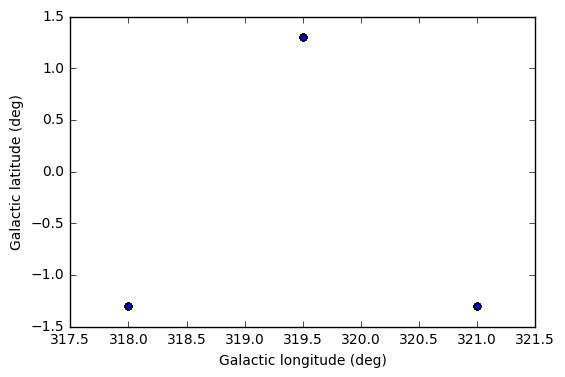

In [11]:
from astropy.coordinates import Angle
plt.scatter(Angle(table['GLON_PNT'], unit='deg'), table['GLAT_PNT'])
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Galactic latitude (deg)')

# MAKE SKYMAP
Define map geometry and an ON region for the image analysis. We use a circle of 0.3deg radius as ON region, knowing that the source is seen as mildly extended (0.12deg) by HESS. 

In [12]:
from regions import CircleSkyRegion
on_radius = 0.3 * u.deg
on_region = CircleSkyRegion(center=pos_target, radius=on_radius)

Define reference image centered on the target

In [13]:
from gammapy.image import SkyImage
xref = pos_target.galactic.l.value
yref = pos_target.galactic.b.value
size = 10 * u.deg
binsz = 0.02 # degree per pixel
npix = int((size / binsz).value)
print(npix)
ref_image = SkyImage.empty(
    nxpix=500, nypix=500, binsz=binsz,
    xref=xref, yref=yref,
    proj='CAR', coordsys='GAL',
)
print(ref_image)

500
Name: None
Data shape: (500, 500)
Data type: float64
Data unit: 
Data mean: 0.000e+00
WCS type: ['GLON-CAR', 'GLAT-CAR']



We use the ring background estimation method, and an exclusion mask that excludes the bright source at the Galactic center.

(<matplotlib.figure.Figure at 0x1100f7eb8>,
 None)

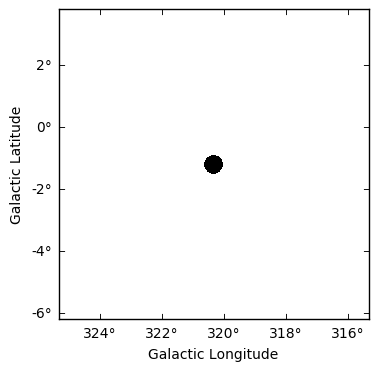

In [14]:
exclusion_mask = ref_image.region_mask(on_region)
exclusion_mask.data = 1 - exclusion_mask.data
exclusion_mask.plot()

In [15]:
from gammapy.background import RingBackgroundEstimator
bkg_estimator = RingBackgroundEstimator(
    r_in=0.6 * u.deg,
    width=0.2 * u.deg,
)

In [16]:
from gammapy.image import IACTBasicImageEstimator
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=200 * u.GeV,
    emax=100 * u.TeV,
    offset_max=3 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=exclusion_mask,
)

The image_estimator contains 6 images. How to know which images it contains

In [17]:
images = image_estimator.run(obs_list)

/Users/roberta/gammapy/gammapy/cube/core.py:76: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/Users/roberta/anaconda2/envs/cta/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:2382: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


In [18]:
print(images)

SkyImageList:
Number of images: 6

Image(index=0, name=counts) properties: 
Name: counts
Data shape: (500, 500)
Data type: float64
Data unit: 
Data mean: 2.237e-01
WCS type: ['GLON-CAR', 'GLAT-CAR']

Image(index=1, name=exposure) properties: 
Name: exposure
Data shape: (500, 500)
Data type: float64
Data unit: 
Data mean: 8.641e+08
WCS type: ['GLON-CAR', 'GLAT-CAR']

Image(index=2, name=background) properties: 
Name: background
Data shape: (500, 500)
Data type: float64
Data unit: 
Data mean: 2.218e-01
WCS type: ['GLON-CAR', 'GLAT-CAR']

Image(index=3, name=excess) properties: 
Name: excess
Data shape: (500, 500)
Data type: float64
Data unit: 
Data mean: 1.929e-03
WCS type: ['GLON-CAR', 'GLAT-CAR']

Image(index=4, name=flux) properties: 
Name: flux
Data shape: (500, 500)
Data type: float64
Data unit: 
Data mean: 8.912e-13
WCS type: ['GLON-CAR', 'GLAT-CAR']

Image(index=5, name=psf) properties: 
Name: psf
Data shape: (500, 500)
Data type: float64
Data unit: 
Data mean: 4.000e-06
WCS type:

In [19]:
print(images.names)

['counts', 'exposure', 'background', 'excess', 'flux', 'psf']


How to show the images. The counts map

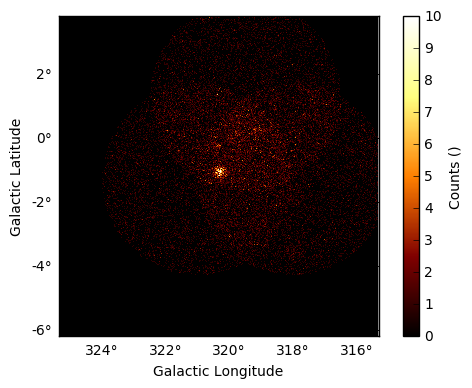

In [20]:
cts_image = images['counts']
cts_image.show(vmin=0,vmax=10,add_cbar=True)

In [21]:
cts_image_cutoff = images['counts'].cutout(position=pos_target,size=(3*u.deg, 3*u.deg),)

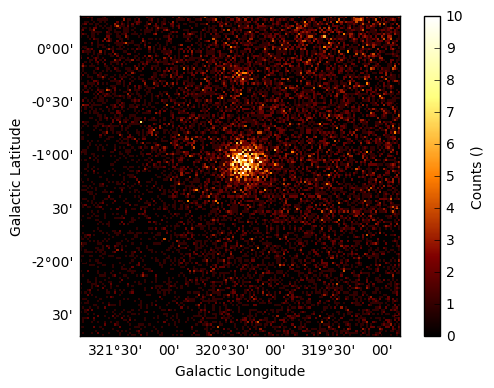

In [22]:
cts_image_cutoff.show(vmin=0,vmax=10,add_cbar=True)

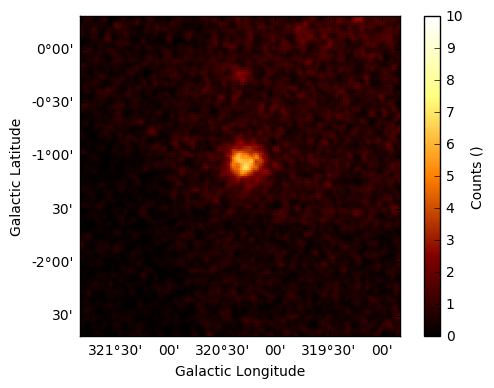

In [23]:
cts_image_cutoff.smooth(radius=2).show(vmin=0,vmax=10,add_cbar=True)
#shift tab for documentation

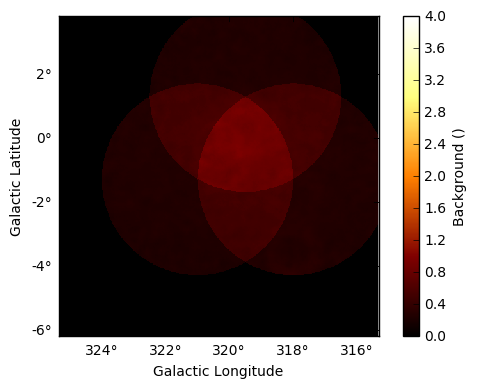

In [24]:
bkg_image = images['background']
bkg_image.show(vmin=0,vmax=4,add_cbar=True)

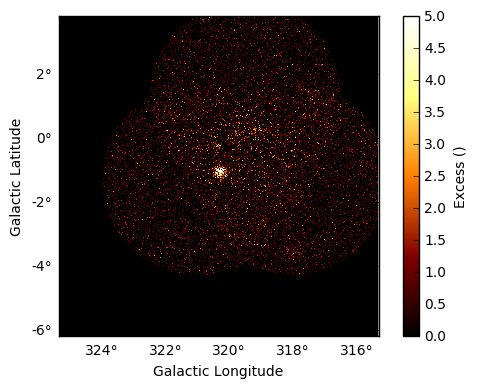

In [25]:
excess_image = images['excess']
excess_image.show(vmin=0,vmax=5,add_cbar=True)

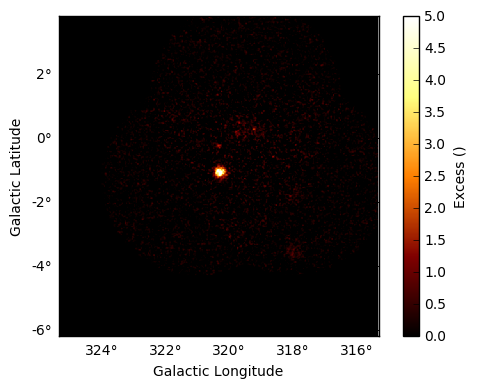

In [26]:
excess_image.smooth(radius=2).show(vmin=0,vmax=5,add_cbar=True)

In [27]:
excess_image_cutoff = excess_image.cutout(position=pos_target,size=(3*u.deg, 3*u.deg),)

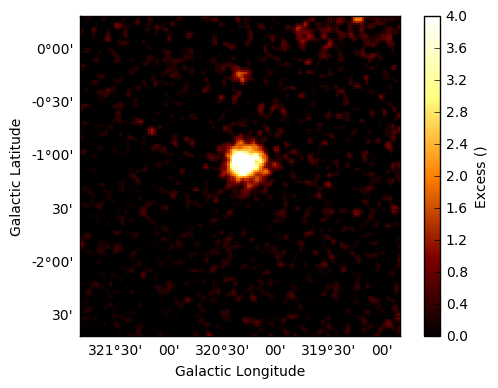

In [28]:
excess_image_cutoff.smooth(radius=2).show(vmin=0,vmax=4,add_cbar=True)

Save the images in fits files to be used later on for an eventual sherpa fitting

In [29]:
from astropy.io import fits
images['counts'].write("../datasets/images/MSH15-52_counts.fits.gz", clobber=True)
images['background'].write("../datasets/images/MSH15-52_background.fits.gz", clobber=True)
images['exposure'].write("../datasets/images/MSH15-52_exposure.fits.gz", clobber=True)
#As psf is an array of quantities we cannot use the images['psf'].write() function
fits.writeto("../datasets/images/MSH15-52_psf.fits.gz",images['psf'].data.value,overwrite=True)

Let's compute the significance map by using the Li&Ma significance definition

In [30]:
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(4)
from gammapy.detect import compute_lima_image
lima_image = compute_lima_image(cts_image,bkg_image,kernel)['significance']

/Users/roberta/gammapy/gammapy/stats/poisson.py:237: RuntimeWarning: invalid value encountered in greater_equal
  mask = (n_on >= n_on_min)


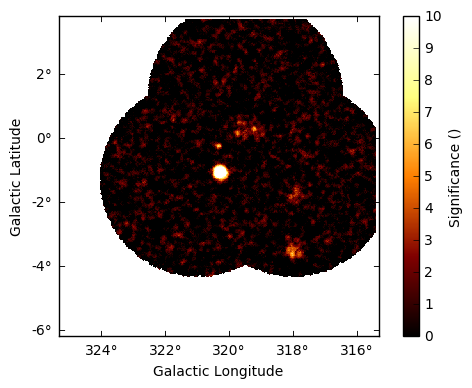

In [31]:
lima_image.show(vmin=0,vmax=10,add_cbar=True)

Let's compute a TS image instead (1D likelihood fit of the source amplitude)

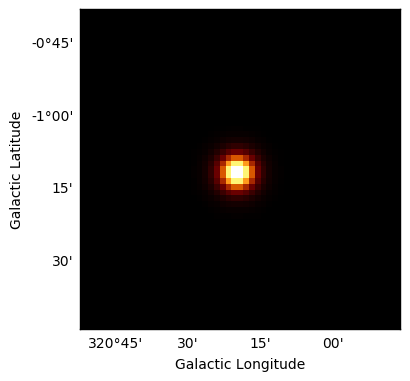

In [32]:
# cut out smaller piece of the PSF image to save computing time
# for covenience we're "misusing" the SkyImage class represent the PSF on the sky.
kernel = images['psf'].cutout(pos_target, size= 1.1 * u.deg)
kernel.show()

In [33]:
from gammapy.detect import TSImageEstimator
ts_image_estimator = TSImageEstimator()
images_ts = ts_image_estimator.run(images, kernel.data)
print(images_ts.names)

['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter']


We run a peak finder on the sqrt_ts image to get a list of sources (positions and peak sqrt_ts values).

In [34]:
from photutils.detection import find_peaks
sources = find_peaks(data=images_ts['sqrt_ts'].data, threshold=5, wcs=images_ts['sqrt_ts'].wcs)
sources

/Users/roberta/anaconda2/envs/cta/lib/python3.5/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


x_peak,y_peak,icrs_ra_peak,icrs_dec_peak,peak_value
,,deg,deg,
int64,int64,float64,float64,float64
365,129,226.971161208,-62.4077864573,7.48916286777
376,129,226.558518122,-62.5169585343,5.07489212548
360,136,227.006927211,-62.2365926311,5.56084742384
252,256,228.314721012,-59.0721619013,32.8441797147
250,297,227.5731937,-58.3471146655,7.22951662732
279,318,226.21779484,-58.2717112907,5.5170977991
306,324,225.206363333,-58.4270947083,6.63222821571


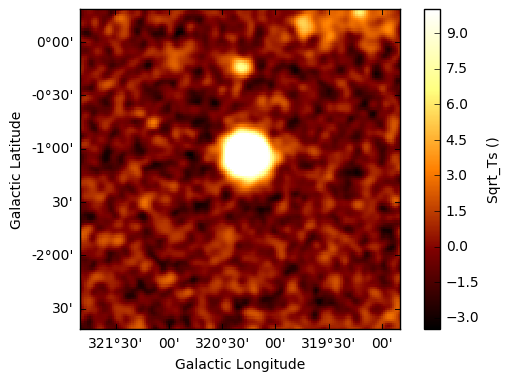

In [35]:
images_ts['sqrt_ts'].cutout(
    position=SkyCoord(pos_target, unit='deg', frame='galactic'),
    size=(3*u.deg, 3*u.deg)).show(add_cbar=True,vmax=10)

# Spectral analysis
We’ll run a spectral analysis using the classical reflected regions background estimation method, and using the on-off (often called WSTAT) likelihood function.

In [36]:
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)

Next we will manually perform a background estimate by placing reflected regions around the pointing position and looking at the source statistics. This will result in a gammapy.background.BackgroundEstimate that serves as input for other classes in gammapy.

In [37]:
from gammapy.background import ReflectedRegionsBackgroundEstimator
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)

In [38]:
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
print(bkg_estimate[0])

BackgroundEstimate
 Method: Reflected Regions
 on region
 Region: CircleSkyRegion
center: <SkyCoord (Galactic): (l, b) in deg
    ( 320.33033806, -1.19304588)>
radius: 0.3 deg
 EventList info:
- Number of events: 1092
- Median energy: 0.17698659002780914 TeV

 off region
 [<CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 320.14483723, -0.38358564)>, radius=0.300000000000158 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 319.83994042,  0.13314066)>, radius=0.2999999999970307 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 319.41345451,  0.55502371)>, radius=0.299999999984854 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 318.89360504,  0.8541904)>, radius=0.2999999999488278 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 318.31474854,  1.01088285)>, radius=0.2999999998796625 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 317.71511156,  1.01475509)>, radius=0.2999999997979047 deg)>, <Ci

(<matplotlib.figure.Figure at 0x113741828>,
 None)

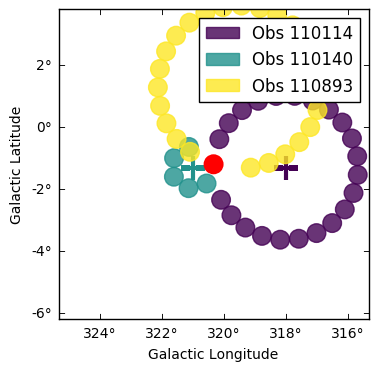

In [39]:
bkg_estimator.plot()

we’re going to look at the overall source statistics in our signal region.

In [40]:
from gammapy.data import ObservationStats, ObservationSummary
stats = []
for obs, bkg in zip(obs_list, bkg_estimator.result):
    stats.append(ObservationStats.from_obs(obs, bkg))
print(stats[0],stats[1],stats[2])    

*** Observation summary report ***
Observation Id: 110114
Livetime: 0.490 h
On events: 1092
Off events: 15015
Alpha: 0.045
Bkg events in On region: 682.50
Excess: 409.50
Excess / Background: 0.60
Gamma rate: 37.14 1 / min
Bkg rate: 23.21 1 / min
Sigma: 14.03
 *** Observation summary report ***
Observation Id: 110140
Livetime: 0.490 h
On events: 2182
Off events: 7576
Alpha: 0.200
Bkg events in On region: 1515.20
Excess: 666.80
Excess / Background: 0.44
Gamma rate: 74.22 1 / min
Bkg rate: 51.54 1 / min
Sigma: 14.50
 *** Observation summary report ***
Observation Id: 110893
Livetime: 0.490 h
On events: 941
Off events: 12849
Alpha: 0.040
Bkg events in On region: 513.96
Excess: 427.04
Excess / Background: 0.83
Gamma rate: 32.01 1 / min
Bkg rate: 17.48 1 / min
Sigma: 16.45



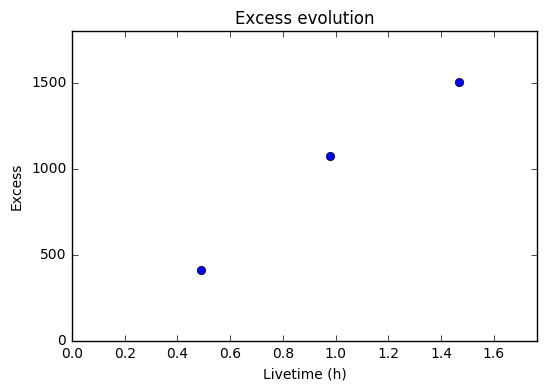

In [41]:
obs_summary = ObservationSummary(stats)
obs_summary.plot_excess_vs_livetime()

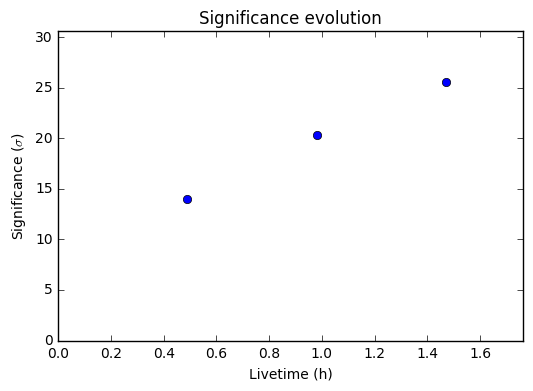

In [42]:
obs_summary.plot_significance_vs_livetime()

Now, we’re going to extract a spectrum using the SpectrumExtraction class. 
Thus, we instantiate a SpectrumExtraction object that will do the extraction. 

In [43]:
extract = SpectrumExtraction(
    obs_list=obs_list,
    bkg_estimate=bkg_estimate,
)

extract.run()

/Users/roberta/anaconda2/envs/cta/lib/python3.5/site-packages/astropy/units/quantity.py:1059: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
No thresholds defined for obs Info for OBS_ID = 110114
- Start time: 59221.50
- Pointing pos: RA 224.61 deg / Dec -60.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %

No thresholds defined for obs Info for OBS_ID = 110140
- Start time: 59222.66
- Pointing pos: RA 229.74 deg / Dec -58.90 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %

No thresholds defined for obs Info for OBS_ID = 110893
- Start time: 59262.50
- Pointing pos: RA 224.81 deg / Dec -57.40 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %



Now we will look at the files we just created. We will use the SpectrumObservation object that are still in memory from the extraction step. Note, however, that you could also read them from disk if you have written them in the step above . The ANALYSIS_DIR folder contains 4 FITS files for each observation. These files are described in detail at https://gamma-astro-data-formats.readthedocs.io/en/latest/ogip/index.html. In short they correspond to the on vector, the off vector, the effectie area, and the energy dispersion.

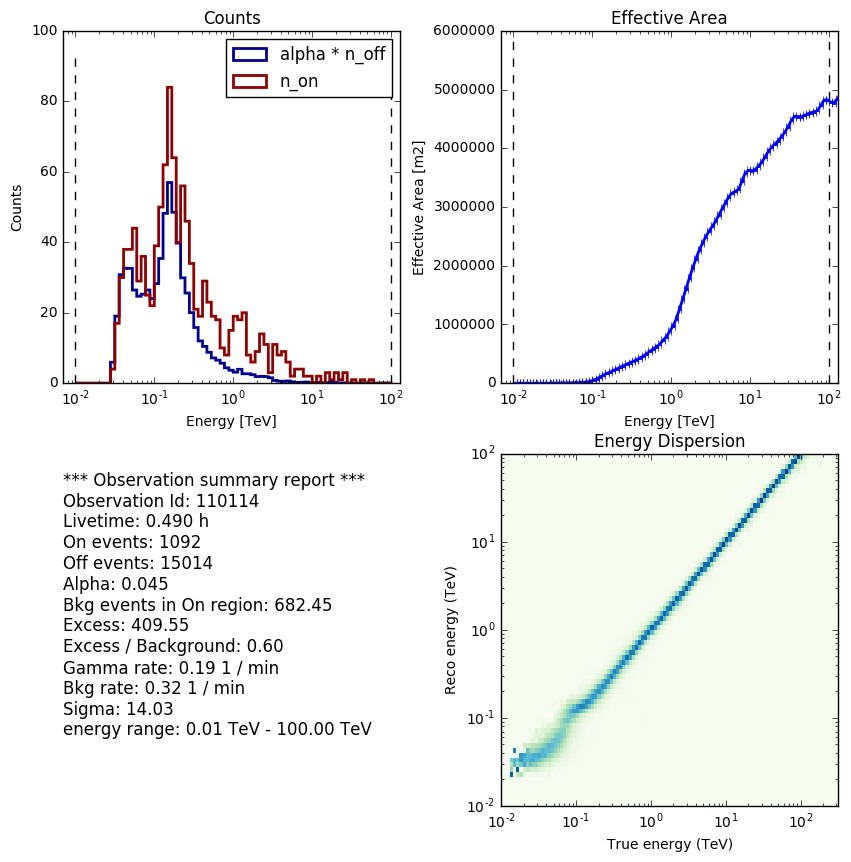

In [44]:
extract.observations[0].peek()

Now we’ll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. 

In [45]:
model = models.PowerLaw(
    index = 2 * u.Unit(''),
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

fit = SpectrumFit(extract.observations, model,
                 fit_range=(1*u.TeV, 10*u.TeV))
#probably not working
fit.fit()
fit.est_errors()
print(fit.result[0])

/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 2.281e+00 9.212e-02                 nan nan  False
	amplitude 5.251e-12 5.185e-13 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True

Covariance: 

	name/name  index   amplitude
	--------- -------- ---------
	    index  0.00849  3.97e-14
	amplitude 3.97e-14  2.69e-25 

Statistic: 25.469 (wstat)
Fit Range: [  1.  10.] TeV



We will also produce a debug plot in order to show how the global fit matches one of the individual observations.

(<matplotlib.axes._subplots.AxesSubplot at 0x110fef278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1135c4eb8>)

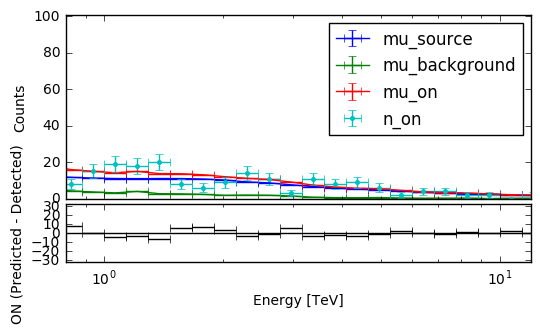

In [46]:
fit.result[0].plot()

we can compute flux points by fitting the norm of the global model in energy bands. We’ll use a fixed energy binning for now.

In [47]:
from gammapy.utils.energy import EnergyBounds
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(0.1, 40, 15, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

print(seg.groups)

*** Observation summary report ***
Observation Id: [110114-110893]
Livetime: 1.470 h
On events: 4215
Off events: 35437
Alpha: 0.077
Bkg events in On region: 2711.53
Excess: 1503.47
Excess / Background: 0.55
Gamma rate: 0.24 1 / min
Bkg rate: 0.43 1 / min
Sigma: 25.56
energy range: 0.01 TeV - 100.00 TeV
SpectrumEnergyGroups:
energy_group_idx bin_idx_min bin_idx_max  bin_type   energy_min     energy_max  
                                                        TeV            TeV      
---------------- ----------- ----------- --------- -------------- --------------
               0           0          17 underflow           0.01            0.1
               1          18          20    normal            0.1 0.146779926762
               2          21          23    normal 0.146779926762 0.215443469003
               3          24          26    normal 0.215443469003 0.316227766017
               4          27          29    normal 0.316227766017 0.464158883361
               5          

/Users/roberta/gammapy/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/Users/roberta/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


In [48]:
fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
print(fpe.flux_points.table)

/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/roberta/gammapy/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))


    e_ref          e_min      ...     dnde_errp         dnde_errn    
     TeV            TeV       ...  1 / (cm2 s TeV)   1 / (cm2 s TeV) 
-------------- -------------- ... ----------------- -----------------
0.121152765863            0.1 ... 8.72061666943e-11 8.42434331388e-11
0.177827941004 0.146779926762 ... 2.91860616342e-11 2.83960429739e-11
0.261015721568 0.215443469003 ... 1.21733786947e-11 1.14997707384e-11
0.383118684956 0.316227766017 ... 5.08208959507e-12 4.93903292311e-12
 0.56234132519 0.464158883361 ... 2.18838444717e-12  2.1044215593e-12
0.825404185268 0.681292069058 ... 8.10530110328e-13 7.62724353178e-13
 1.21152765863            1.0 ... 4.06653805218e-13 3.83733214894e-13
 1.77827941004  1.46779926762 ... 1.47908265419e-13 1.37715246213e-13
 2.78255940221  2.15443469003 ... 5.92433151674e-14 5.54375924633e-14
 4.35400465366   3.5938136638 ... 2.80538814458e-14 2.51206919417e-14
 6.39080484186   5.2749970637 ...  1.4722911577e-14 1.32728898473e-14
  9.3804186664  7.74

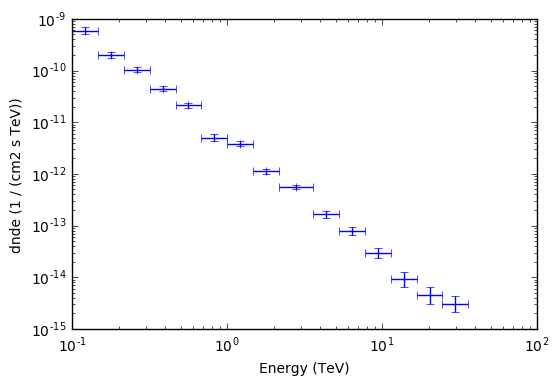

In [49]:
fpe.flux_points.plot()

We try to compare the obtained spectral points and spectral results with the input model in the xml file. 
So far there is no possibility to read xml files from gammapy

In [50]:
!  grep 'MSH' $CTADATA/models/models_gps.xml -A10


  <source name="MSH 15-5-02" type="ExtendedSource">
    <spectrum type="PowerLaw">
      <parameter name="Prefactor" value="569.999993385584" error="0" scale="1e-20" min="0" free="1" />
      <parameter name="Index" value="2.26999998092651" error="-0" scale="-1" min="-10" max="10" free="1" />
      <parameter name="PivotEnergy" value="1" scale="1000000" free="0" />
    </spectrum>
    <spatialModel type="RadialGaussian">
      <parameter name="RA" value="228.3208083735" scale="1" free="0" />
      <parameter name="DEC" value="-59.0817007878937" scale="1" free="0" />
      <parameter name="Sigma" value="0.106666669249535" error="0" scale="1" min="0.0002778" free="1" />
    </spatialModel>


We plug in the spectral parameters of the input model in a gammapy spectral function.

In [51]:
spec_true = models.PowerLaw(
    index = 2.2699 * u.Unit(''),
    amplitude = 569.99999e-20 * u.Unit('cm-2 s-1 MeV-1'),
    reference = 1 * u.TeV,
)

we plot the obtained spectrum with the one in input together

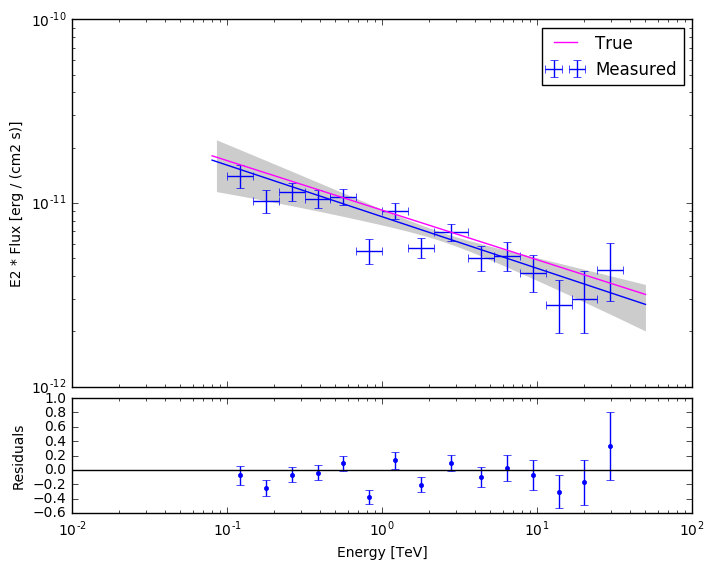

In [52]:
opts = dict(
    energy_range = [0.08, 50] * u.TeV,
    energy_power=2,
    flux_unit='erg-1 cm-2 s-1',
)

total_result = SpectrumResult(
    model=fit.result[0].model,
    points=fpe.flux_points,
)


ax_sed, ax_resid = total_result.plot(
    fig_kwargs=dict(figsize=(8,8)),
    point_kwargs=dict(color='blue', label='Measured'),
    **opts
)

spec_true.plot(
    ax=ax_sed,
    label='True',
    color='magenta',
    **opts
)
ax_sed.legend()

# Sherpa Morphological fit

In [53]:
import sherpa.astro.ui as sh
sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image('../datasets/images/MSH15-52_counts.fits.gz')
sh.set_coord("logical")

sh.load_table_model("expo", "../datasets/images/MSH15-52_exposure.fits.gz")
sh.load_table_model("bkg", "../datasets/images/MSH15-52_background.fits.gz")
sh.load_psf("psf", "../datasets/images/MSH15-52_psf.fits.gz")


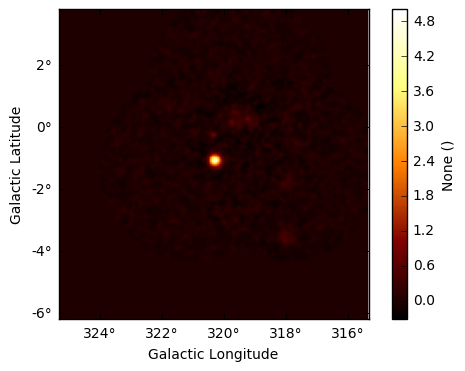

In [54]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=ref_image.wcs)

resid_table=[]  #Keep residual images in a list to show them later
resid_smo6 = resid.smooth(radius = 6)
resid_smo6.plot(vmax=5,add_cbar=True)
resid_table.append(resid_smo6)

In [55]:
maxcoord = resid_smo6.lookup_max()
maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
print(maxcoord)
print(maxpix)
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo) # creates g0 as a gauss2d instance

(<SkyCoord (Galactic): (l, b) in deg
    ( 320.30033297, -1.06304572)>, 4.4984089588222815)
(array(250.99999999999864), array(256.0))


In [56]:
g0.xpos = maxpix[0]
g0.ypos = maxpix[1]
sh.freeze(g0.xpos, g0.ypos) 
expo.ampl = 1e-9
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl)
g0.fwhm = 10
g0.ampl = maxcoord[1]
sh.fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 198875
Final fit statistic   = 198607 at function evaluation 194
Data points           = 250000
Degrees of freedom    = 249998
Change in statistic   = 267.173
   g0.fwhm        12.3647     
   g0.ampl        1.9694      


Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 198607
Final fit statistic   = 198502 at function evaluation 290
Data points           = 250000
Degrees of freedom    = 249996
Change in statistic   = 105.338
   g0.fwhm        11.8251     
   g0.xpos        253.412     
   g0.ypos        256.329     
   g0.ampl        2.16619     
Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   g0.fwhm           11.8251    -0.387663     0.387663
   g0.xpos           253.412    -0.233414     0.233414
   g0.ypos           256.329     -0.23392      0.23392
   g0.ampl           2.16619    -0.134857     0.134857


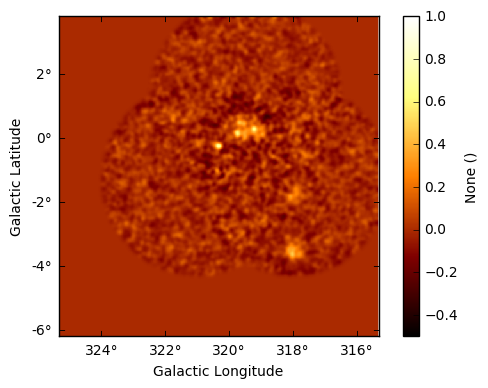

In [57]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.covar()
sh.freeze(g0)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=ref_image.wcs)

resid_smo6 = resid.smooth(radius = 6)
resid_smo6.show(vmin = -0.5, vmax = 1,add_cbar=True)
resid_table.append(resid_smo6)


In [58]:
from astropy.stats import gaussian_fwhm_to_sigma
coord = resid.wcs_pixel_to_skycoord(g0.xpos.val, g0.ypos.val)
pix_scale = resid.wcs_pixel_scale()[0].deg
sigma = g0.fwhm.val * pix_scale * gaussian_fwhm_to_sigma
print('the Sigma is: ', sigma, ' deg')

the Sigma is:  0.100432938964  deg


In [59]:
print(coord)

<SkyCoord (Galactic): (l, b) in deg
    ( 320.25209212, -1.05646917)>


In [60]:
sh.covar()

FitErr: model has no thawed parameters